In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
sys.path.append("./src")

In [2]:
import spacy
import pickle
import torch
import matplotlib.pyplot as plt

from data.tokenizer import Tokenizer
from src.model.mutliclass_duo_attention_net import MulticlassDuoAttentionNet
from data.snli import load_sub_labels
from torch.nn.utils.rnn import pad_sequence

ModuleNotFoundError: No module named 'src.model.binary_luong_attention_net'

In [3]:
spacy_model = spacy.load('en_core_web_md')
tokenizer = Tokenizer(spacy_model)

with open('src/_out/labels/snli_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
val_labels = load_sub_labels('/Uses/dunguyen/Dataset/snli', 'test', 'src/_out')

# binary label
val_labels = val_labels[val_labels['gold_label'] < 2]
val_labels = val_labels[:10]

Load cache SNLI test: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s, path=src/_out/labels/snli_test.csv]


In [4]:
doc1 = [r['sentence1'] for i, r in val_labels.iterrows()]
doc2 = [r['sentence2'] for i, r in val_labels.iterrows()]
y_true = [r['gold_label'] for i, r in val_labels.iterrows()]
    
x1 = [torch.LongTensor(tokenizer.numericalize(d1, vocab)) for d1 in doc1]
x2 = [torch.LongTensor(tokenizer.numericalize(d2, vocab)) for d2 in doc2]

x1_pad = pad_sequence(x1, padding_value=vocab['<pad>'],batch_first=True)
x2_pad = pad_sequence(x2, padding_value=vocab['<pad>'], batch_first=True)
y_true = torch.tensor(y_true, dtype=torch.float)

lemma1 = [tokenizer(d1) for d1 in doc1]
lemma2 = [tokenizer(d2) for d2 in doc2]

* Load model from **checkpoint**

In [5]:
dim_hidden = 300
checkpoint_path = 'src/_out/models/ckpt.LuongAttentionNet.snli.binary.pt'

model = BinaryLuongAttentionNet(vocab, d_hidden=300, method='general')
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluation mode
model.eval()

BinaryLuongAttentionNet(
  (embedding): Embedding(28340, 300, padding_idx=1)
  (lstm): LSTM(300, 300, batch_first=True)
  (attn1v2): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (attn2v1): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (bilinear): Bilinear(in1_features=300, in2_features=300, out_features=1, bias=True)
  (fc): Linear(in_features=600, out_features=300, bias=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

* Load model from **best model**

In [ ]:
model_path = 'src/_out/models/LuongAttentionNet.snli.binary.pt'

model = BinaryLuongAttentionNet(vocab, d_hidden=300, method='general')
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Evaluation mode
model.eval()

### Predict and inference

In [6]:
# Get prediction results
preds, (a1v2, a2v1) = model(x1_pad, x2_pad)
preds = preds.detach()
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [7]:
def hightlight_txt(txt, weights):
    max_alpha = 0.9

    highlighted_text = ''
    
    w_min, w_max = torch.min(weights), torch.max(weights)
    w_norm = (weights - w_min)/(w_max - w_min)
    
    for i in range(len(txt)):
        highlighted_text+= '<span style="background-color:rgba(135,206,250,' \
                                + str(float(w_norm[i]) / max_alpha) + ');">' \
                                + txt[i] + '</span> '
      
    #display(HTML(highlighted_text))
    return highlighted_text

def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item() > 0.5) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

In [8]:
text = visualize(lemma1, lemma2, a2v1, a1v2, preds, y_true)
display(HTML(text))

Plot attention values

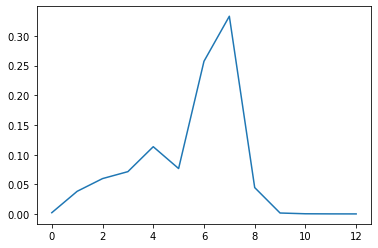

In [52]:
plt.plot(a1v2[0].numpy())

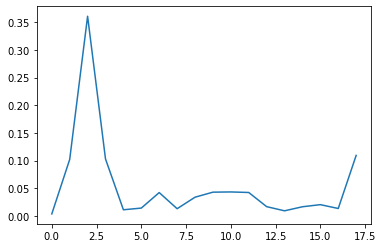

In [55]:
plt.plot(a2v1[1].numpy())

### Test same sentence

In [59]:
preds, (a1v2, a2v1) = model(x1_pad, x1_pad)
preds = preds.detach()
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [60]:
text = visualize(lemma1, lemma1, a2v1, a1v2, preds, y_true)
display(HTML(text))

# Evaluate Softmax

In [13]:
from src.model.multiclass_luong_attention_net import MulticlassLuongAttentionNet

### Load model

In [14]:
dim_hidden = 300
checkpoint_path = 'src/_out/models/ckpt.MultiLuongAttentionNet.snli.multi=2.pt'

model = MulticlassLuongAttentionNet(vocab, d_hidden=300, method='general')
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluation mode
model.eval()

MulticlassLuongAttentionNet(
  (embedding): Embedding(28340, 300, padding_idx=1)
  (lstm): LSTM(300, 300, batch_first=True)
  (attn1v2): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (attn2v1): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (bilinear): Bilinear(in1_features=300, in2_features=300, out_features=1, bias=True)
  (fc): Linear(in_features=600, out_features=300, bias=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

### Predict and Inference

In [21]:
preds, (a1v2, a2v1) = model(x1_pad, x2_pad)
preds = preds.detach()
preds = torch.argmax(preds, dim=1)
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [22]:
text = visualize(lemma1, lemma2, a2v1, a1v2, preds, y_true)
display(HTML(text))

# Evaluate full model for 3 class

In [24]:
dim_hidden = 300
checkpoint_path = 'src/_out/models/ckpt.MultiLuongAttentionNet.snli.multi=3.pt'

model = MulticlassLuongAttentionNet(vocab, d_hidden=300, method='general', n_class=3)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluation mode
model.eval()

MulticlassLuongAttentionNet(
  (embedding): Embedding(28340, 300, padding_idx=1)
  (lstm): LSTM(300, 300, batch_first=True)
  (attn1v2): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (attn2v1): LuongAttention(
    (attn_score): LuongGeneralScore()
  )
  (bilinear): Bilinear(in1_features=300, in2_features=300, out_features=1, bias=True)
  (fc): Linear(in_features=600, out_features=300, bias=True)
  (fc1): Linear(in_features=600, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

### Prepare data for 3 class

In [25]:
with open('src/_out/labels/snli_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
val_labels = load_sub_labels('/Uses/dunguyen/Dataset/snli', 'test', 'src/_out')

val_labels = val_labels[:20]

Load cache SNLI test: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s, path=src/_out/labels/snli_test.csv]


In [26]:
# Get prediction results
preds, (a1v2, a2v1) = model(x1_pad, x2_pad)
preds = preds.detach()
preds = torch.argmax(preds, dim=1)
a1v2 = a1v2.detach()
a2v1 = a2v1.detach()

a2v1 = a2v1.squeeze(dim=1)
a1v2 = a1v2.squeeze(dim=1)

In [31]:
def visualize(lemma1, lemma2, attention1, attention2, pred, y_true):
    html = '<table>'
    html += '<tr> <th>Document 1</th> <th>Document 2</th><th>Prediction</th><th>Label</th> </tr>'
    for i in range(attention1.size(0)):
        html += '<tr> <td>' +  hightlight_txt(lemma1[i], attention1[i]) + '</td><td>' + hightlight_txt(lemma2[i], attention2[i]) +'</td><td>' + str(pred[i].item()) +'</td><td>' + str(y_true[i].item()) +'</td></tr>'
    html += '</table>'
    return html

text = visualize(lemma1, lemma2, a2v1, a1v2, preds, y_true)
display(HTML(text))